## 1. Standard Import

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F
from scipy.signal import convolve2d

In [4]:
# for getting summary info on models
from torchsummary import summary

In [7]:
from torch.utils.data import DataLoader,TensorDataset, Subset
from sklearn.model_selection import train_test_split

In [8]:
import torchvision
import torchvision.transforms as T

## 2. Import the dataset

In [9]:
### Note: resnet is trained for images in a specific range between [-2, 2]
#         That changes the mean/std normalization values in the transform.

# Transformations : to scale the data from -2 to +2 
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # further normalization
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data\stl10_binary.tar.gz to ./data
Files already downloaded and verified


- Above transformations are applied when we pull the data from the dataloaders.

In [10]:
# check out the shape of the datasets
print('Data shapes (train/test):')
print( trainset.data.shape )
print( testset.data.shape )

# the range of pixel intensity values
print('\nData value range:')
print( ( np.min(trainset.data), np.max(trainset.data) ) )

# the unique categories : 10 
print('\nData categories:') 
print( trainset.classes )
# airplane : 0 , bird : 1 .... cat :3 ......dog :5 ....  monkey :7 .....  truck : 9

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(0, 255)

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


## 3. Create DataLoader

In [35]:
batchsize    = 32
train_loader_stl10 = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader_stl10  = DataLoader(testset, batch_size=256)

In [36]:
# Now we can see the transformation.
X,y = next(iter(train_loader_stl10))

# Try again.
print('Data shapes (train/test):')
print( X.data.shape )

# Range of pixel intensity values.
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(2.6400))


In [37]:
y

tensor([1, 9, 5, 7, 9, 1, 5, 4, 3, 1, 1, 4, 5, 3, 6, 5, 4, 0, 3, 4, 5, 8, 7, 0,
        8, 0, 8, 7, 7, 1, 7, 1])

## 4. Visualization of some data

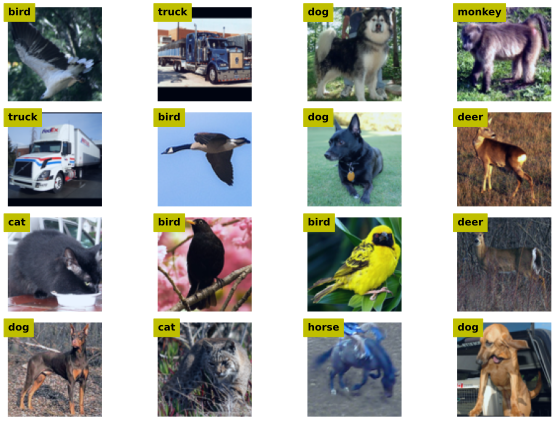

In [38]:
fig,axs = plt.subplots(4,4,figsize=(9,6))

for (i,ax) in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1,2,0))
    
    # valid range for imshow with RGB data ([0..1] for floats
    # undo normalization
    pic = pic-np.min(pic)  
    pic = pic/np.max(pic)

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Import and inspect the resnet model

In [39]:
# The following line was recorded in the video, but is now depreciated. See also Q&A.
# resnet = torchvision.models.resnet18(pretrained=True)

# You can use the following instead. 
weights = torchvision.models.ResNet18_Weights.DEFAULT
resnet =  torchvision.models.resnet18(weights=weights)

In [40]:
# let's inspect this network
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
from torchsummary import summary

summary(resnet,(3,96,96)) ;

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 48, 48]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 48, 48]          128
├─ReLU: 1-3                              [-1, 64, 48, 48]          --
├─MaxPool2d: 1-4                         [-1, 64, 24, 24]          --
├─Sequential: 1-5                        [-1, 64, 24, 24]          --
|    └─BasicBlock: 2-1                   [-1, 64, 24, 24]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 24, 24]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 24, 24]          128
|    |    └─ReLU: 3-3                    [-1, 64, 24, 24]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 24, 24]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 24, 24]          128
|    |    └─ReLU: 3-6                    [-1, 64, 24, 24]          --
|    └─BasicBlock: 2-2                   [-1, 64, 24, 24]          --
|

## 6. Freeze the model layers

In [28]:
# it returns the parameter name along with parameter value
for p in resnet.named_parameters():
    print(p)
    print("********\n")

('conv1.weight', Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e

In [41]:
# it returns only the parameter value
for p in resnet.parameters():
    print(p)
    print("********\n")

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

Parameter containing:
tensor([[[[ 2.8729e-04,  4.2632e-03, -2.0266e-03],
          [ 1.9513e-04,  2.4381e-03, -5.8632e-03],
          [ 4.4803e-03,  8.6577e-03,  8.5538e-04]],

         [[-1.1335e-02, -1.3195e-02, -1.0305e-02],
          [-4.9507e-03, -4.5898e-03, -3.1041e-03],
          [-7.5883e-03, -8.3795e-03, -8.9239e-03]],

         [[-1.1914e-02, -1.2104e-02, -1.0167e-02],
          [-1.2093e-02, -1.1557e-02, -8.9600e-03],
          [-1.2515e-02, -9.3296e-03, -6.4079e-03]],

         ...,

         [[-9.3573e-03, -1.0662e-02, -1.2672e-02],
          [-8.0600e-03, -8.5423e-03, -1.2121e-02],
          [-8.1498e-03, -8.8037e-03, -1.0611e-02]],

         [[ 4.2632e-03,  5.6461e-03,  2.8460e-03],
          [ 4.7070e-03,  6.2550e-03,  7.5862e-03],
          [ 1.1504e-02,  1.1518e-02,  1.0728e-02]],

         [[-6.2455e-03, -9.1693e-03, -9.6664e-03],
          [-4.2935e-03, -6.5311e-03, -5.0513e-03],
          [-3.1141e-03, -5.0124e-03, -5.8122e-03]]],


        [[[ 2.7483e-03,  3.7146

In [42]:
# Freeze all layers (final layer changed later)
for p in resnet.parameters():
    p.requires_grad = False

    # python note: the above operation can be implemented in-line:
    #p.requires_grad_(False)

In [43]:
# Since our categorization problem has 10 categories
# but original ResNet is designed to classify 1000 categories

# So,we need to change the output categorization layer
resnet.fc = nn.Linear(512,10)

## 7. Define the loss function and optimizer

In [44]:
# loss function
lossfunc_resnet = nn.CrossEntropyLoss()

# optimizer
LR = 0.001
optimizer_resnet = torch.optim.Adam(resnet.parameters(),lr=LR)

## 8. Model Training

In [45]:
def function2trainTheModel(Model, lossfunc, optimizer, train_loader, test_loader, epochs):

    losses   = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round(100*torch.mean((torch.argmax(yHat_test,axis=1)==y).float()),2 ) )
        # End epochs

    # function output
    return trainAcc,testAcc,losses,Model

## 9.  Run the model 

In [46]:
# took 10mins 
TrainAcc_resnet,TestAcc_resnet,Losses_resnet,trained_Model_resnet=function2trainTheModel(Model=resnet , 
                                                                     lossfunc=lossfunc_resnet , 
                                                                     optimizer=optimizer_resnet,
                                                                     train_loader=train_loader_stl10 , 
                                                                     test_loader=test_loader_stl10, 
                                                                     epochs=10)

## 10. Results Visualization - STL10

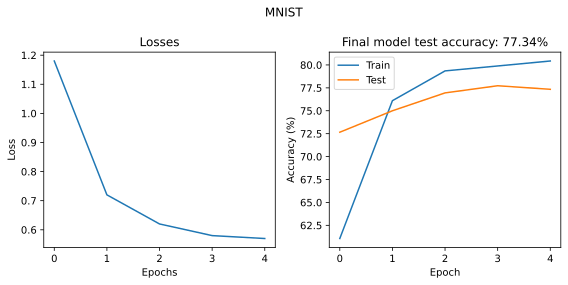

In [47]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].plot(Losses_resnet.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses')

ax[1].plot(TrainAcc_resnet,label='Train')
ax[1].plot(TestAcc_resnet, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'Final model test accuracy: {TestAcc_resnet[-1]:.2f}%')

ax[1].legend()
fig.suptitle("MNIST")
fig.tight_layout()

plt.show()